In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple
import numpy as np

In [2]:
# ---------------------------
# Vector Quantizer Module
# ---------------------------

class VectorQuantizer(nn.Module):
    """
    Implements the vector quantization layer as described in the VQ-VAE paper.
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
        # Create the embedding table
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # inputs shape: (batch, channels, height, width)
        input_shape = inputs.shape
        B, D, H, W = input_shape
        flat_input = inputs.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)  # (B*H*W, D)

        # Compute distances between encoder outputs and embedding weights
        diffs = (flat_input.unsqueeze(0) - self.embedding.weight.unsqueeze(1)) # (num_embs, B*H*W, D)
        distances = torch.norm(diffs, dim=-1) # (num_embs, B*H*W)

        # Get the encoding indices for minimum distances
        encoding_indices = torch.argmin(distances, dim=0) # (B*H*W)
        # Quantize the inputs by replacing them with the nearest embedding vector
        quantized = self.embedding(encoding_indices).reshape(B, H, W, D)
        assert self.embedding(encoding_indices).shape == (B * H * W, D)
        quantized = quantized.permute(0, 3, 1, 2)


        # Compute the loss for embedding commitment and the encoder
        e_latent_loss = ((inputs.detach() - quantized) ** 2).mean()
        q_latent_loss = ((inputs - quantized.detach()) ** 2).mean()
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Use the straight-through estimator to pass gradients
        quantized = quantized.detach() + inputs - inputs.detach()

        # Calculate entropy for monitoring codebook usage
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(flat_input.dtype)
        # encoding: [B * H * W, self.num_embeddings]
        avg_probs = torch.mean(encodings.detach().float(), dim=0)
        entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        return quantized, loss, entropy

    def get_encoding_indices(self, inputs):
        """
        Given encoder outputs, return the latent indices as a (B, H, W) tensor.
        """
        input_shape = inputs.shape  # (B, D, H, W)
        flat_input = inputs.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        distances = ... # TODO
        encoding_indices = ... # TODO
        indices = ... # TODO
        return indices

In [3]:
# ---------------------------
# VQ-VAE Architecture
# ---------------------------
class VQVAE(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=128, embedding_dim=64, 
                 num_embeddings=512, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        # Encoder: two convolutional layers that downsample the image twice.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),  # half resolution
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),  # quarter resolution
            nn.ReLU(),
            nn.Conv2d(hidden_channels, embedding_dim, kernel_size=3, stride=1, padding=1)
        )
        # Vector Quantizer: discretizes the continuous latent space.
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        # Decoder: mirror of the encoder using transposed convolutions.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),  # double resolution
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, entropy = self.vq(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss, entropy
    
    def encode(self, x):
        """
        Returns the discrete latent indices for input x.
        """
        z_e = self.encoder(x)
        indices = self.vq.get_encoding_indices(z_e)
        return indices

In [4]:
def clip_outliers(data, upper_percentile=95):
    """Clip data to remove extreme outliers for better visualization."""
    upper_bound = np.percentile(data, upper_percentile)
    return np.clip(data, 0, upper_bound)

# Drawing function for plotting metrics with enhanced visualization
def draw_metrics(train_metrics, eval_metrics=None):
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    import matplotlib.ticker as ticker
    
    clear_output(wait=True)
    
    # Get iterations
    iterations = train_metrics["iterations"]
    
    # Create a figure with 4 subplots in a row
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Define better colors and styles for visibility
    train_color = '#1f77b4'  # Deeper blue
    eval_color = '#2ca02c'   # Deeper green
    train_linestyle = '-'
    eval_linestyle = '--'
    train_linewidth = 2
    eval_linewidth = 3
    
    # Common styling for all plots
    for ax in axes:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Reconstruction Loss
    clipped_rec_losses = clip_outliers(train_metrics["rec_losses"])
    axes[0].plot(iterations, clipped_rec_losses, label="Train", color=train_color, 
                linestyle=train_linestyle, linewidth=train_linewidth)
    if eval_metrics is not None and len(eval_metrics["rec_losses"]) > 0:
        total_step = eval_metrics["total_step"]
        axes[0].plot(total_step, eval_metrics["rec_losses"], label="Eval", 
                    color=eval_color, linestyle=eval_linestyle, linewidth=eval_linewidth, marker='o', markersize=4)
    axes[0].set_xlabel("Iterations", fontsize=10)
    axes[0].set_ylabel("Loss", fontsize=10)
    axes[0].set_title("Reconstruction Loss", fontweight='bold')
    axes[0].legend(frameon=False)
    
    # VQ Loss
    clipped_vq_losses = clip_outliers(train_metrics["vq_losses"])
    axes[1].plot(iterations, clipped_vq_losses, label="Train", color=train_color, 
                linestyle=train_linestyle, linewidth=train_linewidth)
    if eval_metrics is not None and len(eval_metrics["vq_losses"]) > 0:
        axes[1].plot(total_step, eval_metrics["vq_losses"], label="Eval", 
                    color=eval_color, linestyle=eval_linestyle, linewidth=eval_linewidth, marker='o', markersize=4)
    axes[1].set_xlabel("Iterations", fontsize=10)
    axes[1].set_ylabel("Loss", fontsize=10)
    axes[1].set_title("Vector Quantization Loss", fontweight='bold')
    axes[1].legend(frameon=False)
    
    # Total Loss
    clipped_total_losses = clip_outliers(train_metrics["total_losses"])
    axes[2].plot(iterations, clipped_total_losses, label="Train", color=train_color, 
                linestyle=train_linestyle, linewidth=train_linewidth)
    if eval_metrics is not None and len(eval_metrics["total_losses"]) > 0:
        axes[2].plot(total_step, eval_metrics["total_losses"], label="Eval", 
                    color=eval_color, linestyle=eval_linestyle, linewidth=eval_linewidth, marker='o', markersize=4)
    axes[2].set_xlabel("Iterations", fontsize=10)
    axes[2].set_ylabel("Loss", fontsize=10)
    axes[2].set_title("Total Loss", fontweight='bold')
    axes[2].legend(frameon=False)
    
    # Entropy - no clipping needed as entropy is naturally bounded
    axes[3].plot(iterations, train_metrics["entropies"], label="Train", color=train_color, 
                linestyle=train_linestyle, linewidth=train_linewidth)
    if eval_metrics is not None and len(eval_metrics["entropies"]) > 0:
        axes[3].plot(total_step, eval_metrics["entropies"], label="Eval", 
                    color=eval_color, linestyle=eval_linestyle, linewidth=eval_linewidth, marker='o', markersize=4)
    axes[3].set_xlabel("Iterations", fontsize=10)
    axes[3].set_ylabel("Entropy", fontsize=10)
    axes[3].set_title("Codebook Entropy", fontweight='bold')
    axes[3].legend(frameon=False)
    
    # Add a horizontal line at the maximum possible entropy (log of codebook size)
    if len(train_metrics["entropies"]) > 0:
        max_entropy = np.log(eval_metrics["num_embeddings"])
        axes[3].axhline(y=max_entropy, color='r', linestyle=':', alpha=0.5, 
                       label=f"Max observed: {max_entropy:.1f}")
    
    plt.tight_layout()
    plt.show()
    
    # Return the figure for saving if needed
    return fig

In [5]:
# ---------------------------
# Training and Evaluation
# ---------------------------
def train_epoch(model, dataloader, optimizer, device, total_step=0, train_metrics=None):
    model.train()
    total_loss = 0
    rec_losses = []
    vq_losses = []
    total_losses = []
    entropies = []
    for x, _ in tqdm(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, vq_loss, entropy = model(x)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

        rec_losses.append(recon_loss.item())
        vq_losses.append(vq_loss.item())
        total_losses.append(loss.item())
        entropies.append(entropy.item())
        total_step += 1

        train_metrics["iterations"].append(total_step)
        train_metrics["rec_losses"].append(recon_loss.item())
        train_metrics["vq_losses"].append(vq_loss.item())
        train_metrics["total_losses"].append(loss.item())
        train_metrics["entropies"].append(entropy.item())
    
    return total_loss / len(dataloader.dataset), total_step


def evaluate(model, dataloader, device, total_step=0, eval_metrics=None):
    model.eval()
    total_loss = 0
    rec_losses = []
    vq_losses = []
    total_losses = []
    entropies = []
    num_samples = 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            x_recon, vq_loss, entropy = model(x)
            recon_loss = F.mse_loss(x_recon, x)
            loss = recon_loss + vq_loss
            total_loss += loss.item() * x.size(0)
            
            rec_losses.append(recon_loss.item() * x.size(0))
            vq_losses.append(vq_loss.item() * x.size(0))
            total_losses.append(loss.item() * x.size(0))
            entropies.append(entropy.item() * x.size(0))
            num_samples += x.size(0)
            
    # Prepare a dictionary of evaluation metrics
    eval_metrics["rec_losses"].append(np.sum(rec_losses) / num_samples)
    eval_metrics["vq_losses"].append(np.sum(vq_losses) / num_samples)
    eval_metrics["total_losses"].append(np.sum(total_losses) / num_samples)
    eval_metrics["entropies"].append(np.sum(entropies) / num_samples)
    eval_metrics["total_step"].append(total_step)
    
    return total_loss / len(dataloader.dataset)

In [6]:
# ---------------------------
# Sampling Function
# ---------------------------
def sample(model, device, num_samples=16, latent_shape=(1, 64, 7, 7)):
    """
    Samples new images by randomly choosing latent codes from the codebook.
    For MNIST (28×28) the latent feature map is 7×7.
    For CIFAR-10 (32×32) you may use 8×8 instead.
    """
    model.eval()
    with torch.no_grad():
        batch_size = num_samples
        h, w = latent_shape[2], latent_shape[3]
        # Randomly sample indices in the range of codebook size.
        indices = torch.randint(0, model.vq.num_embeddings, (batch_size, h, w)).to(device)
        # Lookup embedding vectors and reshape to (batch, embedding_dim, h, w).
        quantized = model.vq.embedding(indices).permute(0, 3, 1, 2)
        # Decode the quantized latent representation.
        samples = model.decoder(quantized)
    return samples

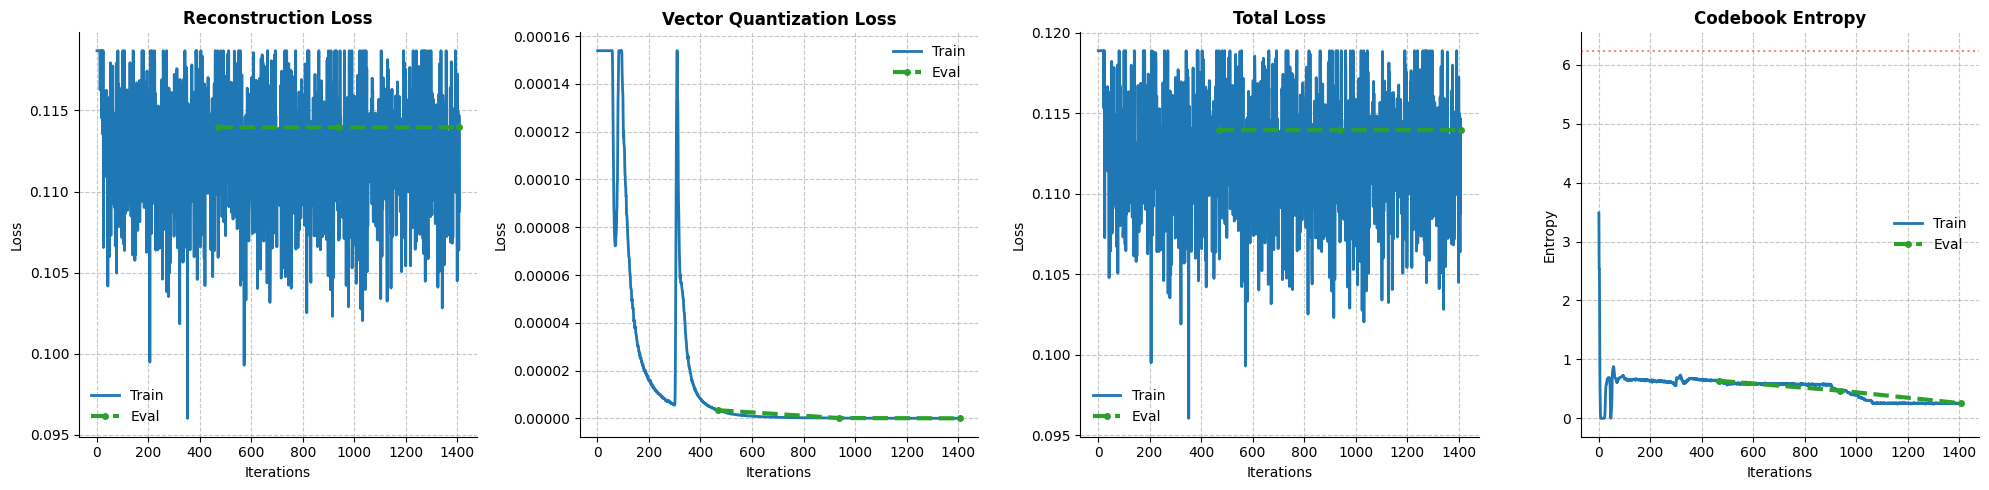

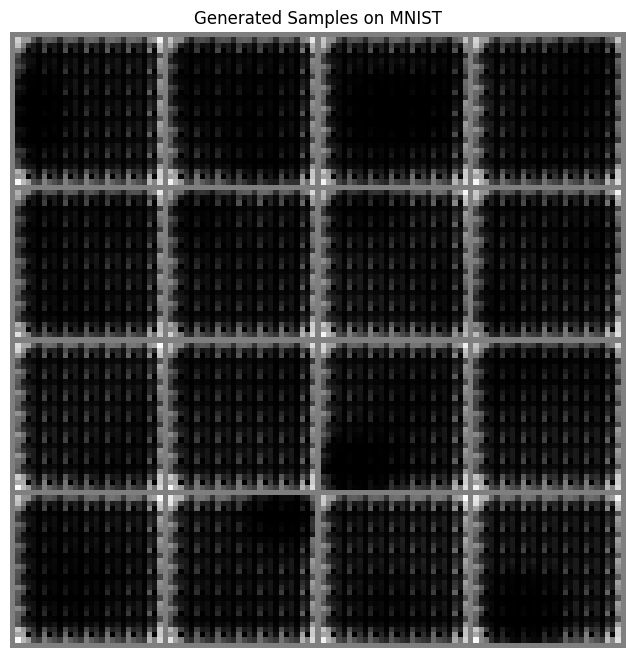

 12%|█▏        | 55/469 [00:00<00:03, 133.14it/s]

 77%|███████▋  | 361/469 [00:02<00:00, 177.05it/s]

In [ ]:
# ---------------------------
# Main Function to Run Training and Sampling
# ---------------------------
dataset = "mnist"
batch_size = 128
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_freq = 1

# Data transformation
transform = transforms.Compose([transforms.ToTensor()])

# Dataset selection and latent shape configuration:
if dataset == 'mnist':
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    in_channels = 1
    # After two stride-2 convolutions, 28×28 images become 7×7.
    latent_shape = (1, 64, 7, 7)
elif dataset == 'cifar10':
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    in_channels = 3
    # For 32×32 images, after two stride-2 layers, the latent map is 8×8.
    latent_shape = (1, 64, 8, 8)
else:
    raise ValueError("Dataset not supported. Choose either 'mnist' or 'cifar10'.")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=10)

# Instantiate the model.
num_embeddings = 512
embed_dim = 64
model = VQVAE(in_channels=in_channels, hidden_channels=128, embedding_dim=embed_dim,
                num_embeddings=num_embeddings, commitment_cost=0.25).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
total_step = 0
train_metrics = {
    "iterations": [],
    "rec_losses": [],
    "vq_losses": [],
    "total_losses": [],
    "entropies": []
}
eval_metrics = {
    "rec_losses": [],
    "vq_losses": [],
    "total_losses": [],
    "entropies": [],
    "total_step": [],
    "num_embeddings": num_embeddings
}

# Training loop.
for epoch in range(1, epochs + 1):
    train_loss, total_step = train_epoch(model, train_loader, optimizer, device, total_step=total_step, train_metrics=train_metrics)
    test_loss = evaluate(model, test_loader, device, total_step=total_step, eval_metrics=eval_metrics)
    
    if epoch % log_freq == 0:
        draw_metrics(train_metrics, eval_metrics)
        # print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Generate and display samples.
        samples = sample(model, device, num_samples=16, latent_shape=latent_shape)
        grid = utils.make_grid(samples.cpu(), nrow=4, normalize=True, padding=1, pad_value=0.5)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.title(f"Generated Samples on {dataset.upper()}")
        plt.axis("off")
        plt.show()


In [8]:
# ---------------------------
# PixelCNN Prior Components
# ---------------------------
class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution as used in autoregressive models.
    Mask type 'A' masks the center pixel as well,
    while type 'B' does not.
    """
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        # Register a mask buffer that is the same size as the weight.
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        center_h = kH // 2
        center_w = kW // 2
        if mask_type == 'A':
            # Mask out center pixel and future pixels.
            self.mask[:, :, center_h, center_w:] = 0
            self.mask[:, :, center_h+1:] = 0
        else:  # Mask type 'B'
            self.mask[:, :, center_h, center_w+1:] = 0
            self.mask[:, :, center_h+1:] = 0

    def forward(self, x):
        return F.conv2d(x, self.weight * self.mask, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class PixelCNN(nn.Module):
    """
    A simple PixelCNN prior to model the distribution of VQ-VAE latent codes.
    """
    def __init__(self, num_embeddings, embed_dim, n_layers=7, hidden_dim=128):
        super(PixelCNN, self).__init__()
        self.num_embeddings = num_embeddings
        # Embed the discrete latent indices
        self.embedding = nn.Embedding(num_embeddings, embed_dim)
        # First layer: MaskedConv2d with mask type 'A'
        self.layers = nn.ModuleList()
        self.layers.append(MaskedConv2d('A', embed_dim, hidden_dim, kernel_size=7, padding=3))
        # Several layers with mask type 'B'
        for _ in range(n_layers - 2):
            self.layers.append(MaskedConv2d('B', hidden_dim, hidden_dim, kernel_size=3, padding=1))
        # Final layer outputs logits over the discrete latent codes.
        self.layers.append(MaskedConv2d('B', hidden_dim, num_embeddings, kernel_size=1))
    
    def forward(self, x):
        # x: (B, H, W) with discrete latent indices.
        x = self.embedding(x)            # (B, H, W, embed_dim)
        x = x.permute(0, 3, 1, 2)          # (B, embed_dim, H, W)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        logits = self.layers[-1](x)       # (B, num_embeddings, H, W)
        return logits

In [9]:
# ---------------------------
# Training Functions for PixelCNN Prior
# ---------------------------
def train_pixelcnn(prior_model, vqvae, dataloader, optimizer, device):
    """
    For each batch, we obtain latent indices using the frozen VQ-VAE encoder,
    then train the PixelCNN to predict the latent code at each spatial location.
    """
    prior_model.train()
    total_loss = 0.0
    for x, _ in dataloader:
        x = x.to(device)
        # Get latent indices from VQ-VAE (VQ-VAE is frozen)
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
            latent_indices = vqvae.encode(x)  # (B, H, W)
        logits = prior_model(latent_indices)  # (B, num_embeddings, H, W)
        loss = F.cross_entropy(logits, latent_indices)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate_pixelcnn(prior_model, vqvae, dataloader, device):
    prior_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            latent_indices = vqvae.encode(x)
            logits = prior_model(latent_indices)
            loss = F.cross_entropy(logits, latent_indices)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

In [10]:
def sample_from_prior(prior_model, latent_shape, device):
    """
    Autoregressively sample a grid of latent indices from the PixelCNN prior.
    latent_shape: tuple (B, D, H, W) where only H and W are used.
    """
    prior_model.eval()
    B, H, W = latent_shape[0], latent_shape[2], latent_shape[3]
    samples = torch.zeros((B, H, W), dtype=torch.long, device=device)
    with torch.no_grad():
        for i in range(H):
            for j in range(W):
                logits = prior_model(samples)  # (B, num_embeddings, H, W)
                probs = F.softmax(logits[:, :, i, j], dim=1)  # (B, num_embeddings)
                sample_idx = torch.multinomial(probs, num_samples=1).squeeze(-1)
                samples[:, i, j] = sample_idx
    return samples

In [11]:
def sample_autoregressive(prior_model, vqvae, device, num_samples=16, latent_shape=(1, 64, 7, 7)):
    """
    Samples new images by first autoregressively generating latent indices from PixelCNN,
    then decoding them using the VQ-VAE decoder.
    """
    latent_shape = (num_samples, latent_shape[1], latent_shape[2], latent_shape[3])
    latent_indices = sample_from_prior(prior_model, latent_shape, device)  # (B, H, W)
    # Lookup embedding vectors from the VQ-VAE codebook.
    quantized = vqvae.vq.embedding.weight[latent_indices].permute(0, 3, 1, 2).contiguous()
    samples = vqvae.decoder(quantized)
    return samples

In [12]:
# Freeze VQ-VAE (set to evaluation mode).
model.eval()
# Instantiate PixelCNN Prior.
prior_model = PixelCNN(num_embeddings=num_embeddings, embed_dim=embed_dim, n_layers=2, hidden_dim=128).to(device)
prior_optimizer = optim.Adam(prior_model.parameters(), lr=1e-3)

Training PixelCNN Prior...


/tmp/ipykernel_2372956/1813540089.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):


Epoch 1: PixelCNN Train Loss: 2.0569, Test Loss: 1.8399
Epoch 2: PixelCNN Train Loss: 1.8050, Test Loss: 1.7863
Epoch 3: PixelCNN Train Loss: 1.7597, Test Loss: 1.7679
Epoch 4: PixelCNN Train Loss: 1.7350, Test Loss: 1.7507
Epoch 5: PixelCNN Train Loss: 1.7197, Test Loss: 1.7428
Epoch 6: PixelCNN Train Loss: 1.7096, Test Loss: 1.7443
Epoch 7: PixelCNN Train Loss: 1.7036, Test Loss: 1.7369
Epoch 8: PixelCNN Train Loss: 1.6984, Test Loss: 1.7403
Epoch 9: PixelCNN Train Loss: 1.6945, Test Loss: 1.7363
Epoch 10: PixelCNN Train Loss: 1.6920, Test Loss: 1.7384
Epoch 11: PixelCNN Train Loss: 1.6890, Test Loss: 1.7348
Epoch 12: PixelCNN Train Loss: 1.6876, Test Loss: 1.7359
Epoch 13: PixelCNN Train Loss: 1.6853, Test Loss: 1.7369
Epoch 14: PixelCNN Train Loss: 1.6843, Test Loss: 1.7339
Epoch 15: PixelCNN Train Loss: 1.6825, Test Loss: 1.7350
Epoch 16: PixelCNN Train Loss: 1.6814, Test Loss: 1.7374
Epoch 17: PixelCNN Train Loss: 1.6802, Test Loss: 1.7356
Epoch 18: PixelCNN Train Loss: 1.6792, T

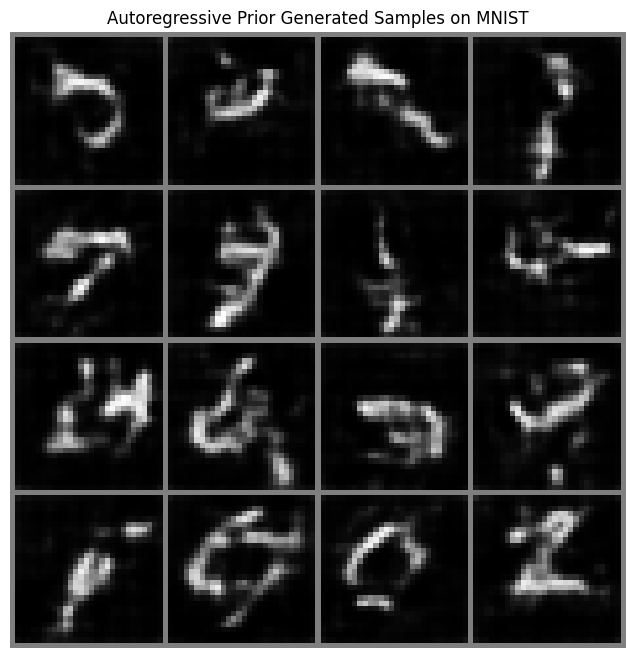

In [13]:
# ---------------------------
# Train the PixelCNN Prior
# ---------------------------
prior_epochs = 10

print("Training PixelCNN Prior...")
for epoch in range(1, prior_epochs + 1):
    train_loss = train_pixelcnn(prior_model, model, train_loader, prior_optimizer, device)
    test_loss = evaluate_pixelcnn(prior_model, model, test_loader, device)
    print(f"Epoch {epoch}: PixelCNN Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Autoregressive sampling from the prior.
samples = sample_autoregressive(prior_model, model, device, num_samples=16, latent_shape=latent_shape)
grid = utils.make_grid(samples.cpu(), nrow=4, normalize=True, padding=1, pad_value=0.5)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.title(f"Autoregressive Prior Generated Samples on {dataset.upper()}")
plt.axis("off")
plt.show()